# 9517 Proj

## 1. Import library

In [48]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import pickle
import itertools

# need to delete
from skimage import feature as ft

## 2. Define functions to extract features

In [49]:
def get_color_hist(image, nbins, bins_range):
    '''
    Functions to extract histogram features
    '''
    # compute histogram from R, G, B 3-dim
    R_hist = np.histogram(image[:, :, 0], bins = nbins, range = bins_range)
    G_hist = np.histogram(image[:, :, 1], bins = nbins, range = bins_range)
    B_hist = np.histogram(image[:, :, 2], bins = nbins, range = bins_range)
    # concatenate the histograms to a single histogram features
    hist_features = np.concatenate((R_hist[0], G_hist[0], B_hist[0]))
    return hist_features

In [50]:
def get_hog_feature(image):
    '''
    Functions to extract hog features
    '''
    features, hog_image = ft.hog(image, orientations=12, pixels_per_cell=[20, 20], cells_per_block=[2,2], visualize = True, transform_sqrt= False)
    return features, hog_image

In [51]:
def extract_features(image):
    features = []
    hog_features = []
    # hog feature
    for channel in range(image.shape[2]):
        fea, hog_image = get_hog_feature(image[:, :, channel])
        hog_features.append(fea)
    hog_features = np.ravel(hog_features)
    features.append(hog_features)
    # histogram feature
    nbins = 32
    bin_range = (0, 256)
    features.append(get_color_hist(image, nbins, bin_range))
    return np.concatenate(features)

In [52]:
def feature_hog_test():
    img_dir = './data/train/clips/1/imgs/040.jpg'
    img = cv2.imread(img_dir)
    
    gt_dir = './data/train/clips/1/annotation.json'
    labels = get_ground_truth(gt_dir)
    label=labels[0]
    left = int(label['left'])
    right = int(label['right'])
    top = int(label['top'])
    bot = int(label['bottom'])
    img_car = img[top:bot, left:right]
    img_no_car = img[0:top, 0:left]

    img_car_extract = get_hog_feature(img_car)[1]
    img_no_car_extract = get_hog_feature(img_no_car)[1]

    fig, axes = plt.subplots(2, 2)
    axes = axes.flatten()
    imgs = [img_car, img_car_extract, img_no_car, img_no_car_extract]
    titiles = ['car img', 'car img extract', 'no car img', 'no car img extract']
    for i in range(4):
        axes[i].imshow(imgs[i], cmap="gray")
        axes[i].set_title(titiles[i])
        axes[i].set_axis_off()
    fig.show()
    fig.savefig('imgs.png', dpi=600, format='png')
    

    return img_car_extract


C:\Users\wjh\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


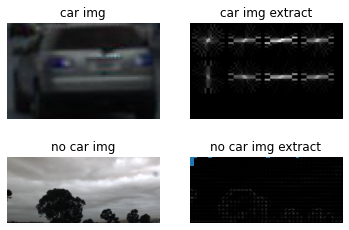

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
feature_test()

In [54]:
def feature_his_test():
    img_dir = './data/train/clips/1/imgs/040.jpg'
    img = cv2.imread(img_dir)
    
    gt_dir = './data/train/clips/1/annotation.json'
    labels = get_ground_truth(gt_dir)
    label=labels[0]
    left = int(label['left'])
    right = int(label['right'])
    top = int(label['top'])
    bot = int(label['bottom'])
    img_car = img[top:bot, left:right]
    img_no_car = img[0:top, 0:left]

    nbins = 32
    bin_range = (0, 256)
    img_car_color_extract = get_color_hist(img_car,  nbins, bin_range)
    img_car_no_color_extract = get_color_hist(img_no_car,  nbins, bin_range)

    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    imgs = [img_car_color_extract, img_car_no_color_extract]
    titiles = ['car img color histogram', 'no car img color histogram']
    for i in range(2):
        axes[i].hist(imgs[i], bins=nbins)
        axes[i].set_title(titiles[i])
        axes[i].set_axis_off()
    fig.show()
    fig.savefig('feature_his_test.png', dpi=600, format='png')




C:\Users\wjh\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


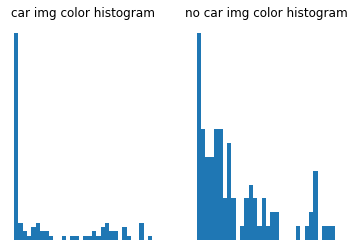

In [55]:
feature_his_test()

## 3. Prepare dataset (train and test)

In [56]:
def get_data(basePath, clips_size, labelType):
    '''
    labelType: 1 as positive -1 as negtive
    '''
    train_data = []
    for index in range(1, clips_size + 1):
        imgs = []
        if index % 10 == 0:
            print('processing on', index)
        # store all train image into list
        img_dir = basePath + str(index) + '/imgs/040.jpg'
        gt_dir = basePath + str(index) + '/annotation.json'
        labels = get_ground_truth(gt_dir)
        

        img = cv2.imread(img_dir)
        if labelType == -1:
            min_left =  9999
            min_top = 9999
            max_right = 0
            max_bottom = 0
            # extract nocar image
            for label in labels:
                left = int(label['left'])
                top = int(label['top'])
                right = int(label['right'])
                bottom = int(label['bottom'])

                min_left = min(left, min_left)
                min_top = min(top, min_top)
                max_right = max(right, max_right)
                max_bottom = max(bottom, max_bottom)
            
            img_left_top = img[0:min_top, 0:min_left]
            img_right_bottom = img[max_bottom:720, max_right:1280]

            imgs.append(img_left_top)
            imgs.append(img_right_bottom)

            # imgs.append(new_img)
            # 1280 * 750
        else:
            for label in labels:
                left = int(label['left'])
                right = int(label['right'])
                top = int(label['top'])
                bot = int(label['bottom'])
                tmp_img = img[top:bot, left:right]
                imgs.append(tmp_img)
        
        for img in imgs:
            img = cv2.resize(img, (150, 150))
            feature_img = extract_features(img)
            train_data.append(feature_img)
            # store all labels into list
            train_data = list(itertools.chain(train_data))
    return train_data

In [57]:
def get_supp_data(basePath):
    train_data = []
    for index in range(10, 60):
        imgs = []
        if index % 10 == 0:
            print('processing on', index)
        # store all train image into list
        img_dir = basePath + 'supp_img/00' + str(index) + '.jpg'
        gt_dir = basePath + '/annotation.json'
        labels = get_supp_truth(gt_dir, index)

        img = cv2.imread(img_dir)
        for label in labels[0]:
            left = int(label['left'])
            right = int(label['right'])
            top = int(label['top'])
            bot = int(label['bottom'])
            tmp_img = img[top:bot, left:right]
            if len(tmp_img) != 0:
                imgs.append(tmp_img)
        
        for img in imgs:
            print(len(img))
            img = cv2.resize(img, (150, 150))
            feature_img = extract_features(img)
            train_data.append(feature_img)
            # store all labels into list
            train_data = list(itertools.chain(train_data))
    return train_data



In [58]:
def get_train_dataset(clips_size):
    basePath = './data/train/clips/'
    print("car......")
    car_train_data = get_data(basePath, clips_size, 1)
    print("non-car......")
    noncar_train_data = get_data(basePath, int(clips_size / 2), -1)
    train_data = np.vstack((car_train_data, noncar_train_data))
    labels = np.hstack((np.ones(len(car_train_data)), np.zeros(len(noncar_train_data))))

    # add supp pic data
    # supp_path = './data/supp/'
    # supp_data = get_supp_data(supp_path)
    # train_data = np.vstack((train_data, supp_data))
    # labels = np.hstack((labels, np.ones(len(supp_data))))
    
    return train_data, labels

In [59]:
def get_test_dataset(clips_size):
    basePath = './data/test/clips/'
    print("car......")
    car_train_data = get_data(basePath, clips_size, 1)
    print("non-car......")
    noncar_train_data = get_data(basePath, int(clips_size / 2), -1)
    train_data = np.vstack((car_train_data, noncar_train_data))
    labels = np.hstack((np.ones(len(car_train_data)), np.zeros(len(noncar_train_data))))
    return np.array(train_data), labels

In [60]:
def get_ground_truth(filepath):
    labels = []
    gt = pd.read_json(filepath)
    list = gt['bbox'].tolist()
    for car in list:
        labels.append(car)
    return labels

In [61]:
def get_supp_truth(filepath, index):
    labels = []
    gt = pd.read_json(filepath)

    gt = gt[gt['file_name']=='supp_img/00' + str(index) + '.jpg']
    list = gt['bbox'].tolist()
    for car in list:
        labels.append(car)
    return labels

## 2. SVM construction

In [62]:
train_data, train_labels = get_train_dataset(1074)

car......
processing on 10
processing on 20
processing on 30
processing on 40
processing on 50
processing on 60
processing on 70
processing on 80
processing on 90
processing on 100
processing on 110
processing on 120
processing on 130
processing on 140
processing on 150
processing on 160
processing on 170
processing on 180
processing on 190
processing on 200
processing on 210
processing on 220
processing on 230
processing on 240
processing on 250
processing on 260
processing on 270
processing on 280
processing on 290
processing on 300
processing on 310
processing on 320
processing on 330
processing on 340
processing on 350
processing on 360
processing on 370
processing on 380
processing on 390
processing on 400
processing on 410
processing on 420
processing on 430
processing on 440
processing on 450
processing on 460
processing on 470
processing on 480
processing on 490
processing on 500
processing on 510
processing on 520
processing on 530
processing on 540
processing on 550
processin

In [63]:
print("test..........")
test_data, test_labels = get_test_dataset(200)

test..........
car......
processing on 10
processing on 20
processing on 30
processing on 40
processing on 50
processing on 60
processing on 70
processing on 80
processing on 90
processing on 100
processing on 110
processing on 120
processing on 130
processing on 140
processing on 150
processing on 160
processing on 170
processing on 180
processing on 190
processing on 200
non-car......
processing on 10
processing on 20
processing on 30
processing on 40
processing on 50
processing on 60
processing on 70
processing on 80
processing on 90
processing on 100


In [64]:
def svm_train(train_data, train_labels, test_data, test_labels):
    # import svc model
    svc = LinearSVC()
    # fit the data
    svc.fit(train_data, train_labels)
    with open('model', 'wb') as f:
        pickle.dump(svc, f)
    
    test_acc = svc.score(test_data, test_labels)
    print('Test Accuracy: {}'.format(round(test_acc, 4)))

    return svc


In [70]:
svm_train(train_data, train_labels, test_data, test_labels)

Test Accuracy: 0.9332
C:\Users\wjh\AppData\Local\Programs\Python\Python36-32\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

## 3. Descide Whether Have Cars Based On  The Model

In [73]:
def slice_window(img, xy_window=(200, 100), xy_overlap=(0.2, 0.2)):
    x_start_stop = [0, img.shape[1]]
    y_start_stop = [0, img.shape[0]]
    # count the size of slice window
    x_size = x_start_stop[1] - x_start_stop[0]
    y_size = y_start_stop[1] - y_start_stop[0]
    # count the num of pixel need for one step
    x_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    y_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # count the num of windows
    x_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    y_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    x_windows = np.int((x_size - x_buffer) / x_pix_per_step)
    y_windows = np.int((y_size - y_buffer) / y_pix_per_step)
    
    # count 
    window_list = []
    print('slicing windows....')
    for y in range(y_windows):
        for x in range(x_windows):
            startx = x * x_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = y * y_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [74]:
def search_window(img, clf, xy_window=(200, 100), xy_overlap=(0.8, 0.8)):
    windows = slice_window(img, xy_window, xy_overlap)

    on_windows = []
    for window in windows:
        new_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        new_img = cv2.resize(new_img, (150, 150))
        features = extract_features(new_img).reshape(1, -1)
        pred = clf.predict(features)
        if pred == 1:
            on_windows.append(window)

    return on_windows

In [188]:
def find_cars(index, xy_window):
    img_dir = './data/test/clips/' + str(index)+ '/imgs/040.jpg'
    img = cv2.imread(img_dir)
    dist_pickle = pickle.load(open("model", "rb"))

    # img = cv2.resize(img, (320, 180))
    # test_img = img[0:320, 0:180]
    # plt.imshow(test_img)
    # plt.show()
    # test_img = cv2.resize(test_img, (320, 180))
    # features = extract_features(test_img).reshape(1, -1)
    # res = dist_pickle.predict(features)
    # print(res)


    on_windows = search_window(img, dist_pickle, xy_window= xy_window, xy_overlap=(0.2, 0.2))


    sum_1 = 0
    sum_2 = 0
    sum_3 = 0
    sum_4 = 0

    # startx, starty, endx, endy
    for window in on_windows:
        sum_1 += window[0][0]
        sum_2 += window[0][1]
        sum_3 += window[1][0]
        sum_4 += window[1][1]

    count = len(on_windows)

    cv2.rectangle(img, (int(sum_1 / count), int(sum_2 / count)), (int(sum_3 / count), int(sum_4 / count)), (0,0,255), 2)


    plt.imshow(img)
    plt.show()
    return [int(sum_2 / count), int(sum_3 / count), int(sum_1 / count), int(sum_4 / count)]

In [185]:
def get_distance_label(distance):
    if distance < 50:
        return 0
    elif distance < 100:
        return 1
    else:
        return 2

def accuracy(pred_list, gt_list):
    all_label = 0
    for index in range(len(pred_list)):
        ve0 = abs(pred_list[index][0] - gt_list[index][0])
        ve1 = abs(pred_list[index][1] - gt_list[index][1])
        ve2 = abs(pred_list[index][2] - gt_list[index][2])
        ve3 = abs(pred_list[index][3] - gt_list[index][3])
        label = get_distance_label((ve0 + ve1 + ve2 + ve3) / 3)
        all_label += label


    return all_label / (2 * len (pred_list))

In [186]:
pred_list = []
gt_list = []
for index in range(10, 20):
    result = find_cars(index, (120, 120))
    gt_dir = './data/test/clips/' + str(index) + '/annotation.json'
    labels = get_ground_truth(gt_dir)[0]
    labels = [labels['top'], labels['right'], labels['left'], labels['bottom']]
    pred_list.append(result)
    gt_list.append(labels)
acc = accuracy(pred_list, gt_list)
print(acc)

slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
slicing windows....
0.25


slicing windows....


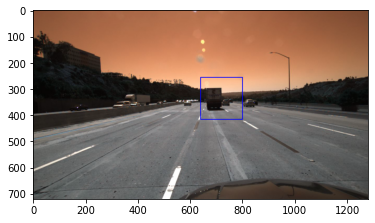

In [106]:
result = find_cars(6, (160, 160))

slicing windows....


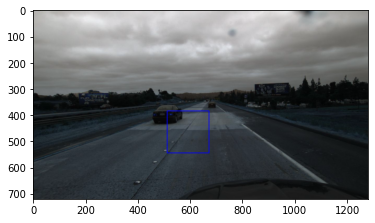

In [115]:
result = find_cars(9, (160, 160))

slicing windows....


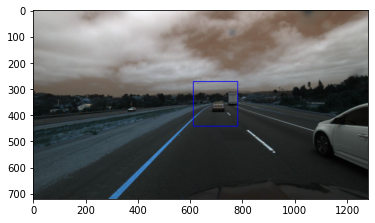

In [116]:
result = find_cars(13, (170, 170))

slicing windows....


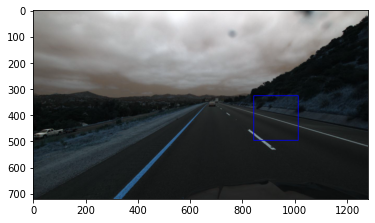

In [189]:
result = find_cars(5, (170, 170))